<a href="https://colab.research.google.com/github/KennyZhang-17/CS-Notes/blob/master/535_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Code to unpack pickle files. 

@author: Zhaoqi Li
"""

import pickle
import numpy as np

with open('/content/image-train', 'rb') as f:
    X_train = pickle.load(f)
with open('/content/label-train', 'rb') as f:
    y_train = pickle.load(f)

np.savetxt("image-train.txt", X_train)
np.savetxt("label-train.txt", y_train)

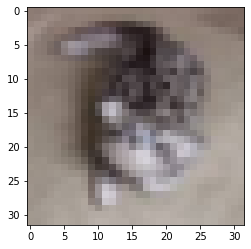

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#X_train=np.loadtxt('image-train.txt' )
#y_train=np.loadtxt("label-train.txt")
plt.imshow(np.transpose(np.reshape(X_train[5],(3,32,32)),(1,2,0)).astype('uint8'))
plt.show()

In [4]:
#Import needed packages
import torch
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import numpy as np


class Unit(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Unit,self).__init__()
        

        self.conv = nn.Conv2d(in_channels=in_channels,kernel_size=3,out_channels=out_channels,stride=1,padding=1)
        self.bn = nn.BatchNorm2d(num_features=out_channels)
        self.relu = nn.ReLU()

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.relu(output)

        return output

class SimpleNet(nn.Module):
    def __init__(self,num_classes=10):
        super(SimpleNet,self).__init__()

        #Create 14 layers of the unit with max pooling in between
        self.unit1 = Unit(in_channels=3,out_channels=32)
        self.unit2 = Unit(in_channels=32, out_channels=32)
        self.unit3 = Unit(in_channels=32, out_channels=32)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.unit4 = Unit(in_channels=32, out_channels=64)
        self.unit5 = Unit(in_channels=64, out_channels=64)
        self.unit6 = Unit(in_channels=64, out_channels=64)
        self.unit7 = Unit(in_channels=64, out_channels=64)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.unit8 = Unit(in_channels=64, out_channels=128)
        self.unit9 = Unit(in_channels=128, out_channels=128)
        self.unit10 = Unit(in_channels=128, out_channels=128)
        self.unit11 = Unit(in_channels=128, out_channels=128)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.unit12 = Unit(in_channels=128, out_channels=128)
        self.unit13 = Unit(in_channels=128, out_channels=128)
        self.unit14 = Unit(in_channels=128, out_channels=128)

        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        #Add all the units into the Sequential layer in exact order
        self.net = nn.Sequential(self.unit1, self.unit2, self.unit3, self.pool1, self.unit4, self.unit5, self.unit6
                                 ,self.unit7, self.pool2, self.unit8, self.unit9, self.unit10, self.unit11, self.pool3,
                                 self.unit12, self.unit13, self.unit14, self.avgpool)

        self.fc = nn.Linear(in_features=128,out_features=num_classes)

    def forward(self, input):
        output = self.net(input)
        output = output.view(-1,128)
        output = self.fc(output)
        return output

#Define transformations for the training set, flip the images randomly, crop out and apply mean and std normalization
#train_transformations = transforms.Compose([
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomCrop(32,padding=4),
#    transforms.ToTensor(),
#    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#])

batch_size = 32

In [5]:
len(X_train)

40000

In [7]:
X_small=X_train[0:20000]
X_s=np.zeros((20000,3,32,32))
for i in range (20000):
    X_s[i,]=np.reshape(X_small[i],(3,32,32))
X_s=torch.from_numpy(X_s)
Y_s=y_train[0:20000]
Y_s=torch.from_numpy(Y_s)

X_small2=X_train[30000:31000]
X_t=np.zeros((1000,3,32,32))
for i in range (1000):
    X_t[i,]=np.reshape(X_small2[i],(3,32,32))
X_t=torch.from_numpy(X_t)
Y_t=y_train[30000:31000]
Y_t=torch.from_numpy(Y_t)

In [8]:
from torch.utils.data import TensorDataset
train_set=TensorDataset( X_s, Y_s )
test_set=TensorDataset( X_t, Y_t )

In [48]:
#Load the training set
#train_set = X_s,Y_s

#Create a loder for the training set
train_loader = DataLoader(train_set,batch_size=batch_size,shuffle=True,num_workers=4)


#Define transformations for the test set
#test_transformations = transforms.Compose([
#   transforms.ToTensor(),
#    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))

#])

#Load the test set, note that train is set to False
#test_set = X_t, Y_t
#Create a loder for the test set, note that both shuffle is set to false for the test loader
test_loader = DataLoader(test_set,batch_size=batch_size,shuffle=False,num_workers=1)

#Check if gpu support is available
cuda_avail = torch.cuda.is_available()

#Create model, optimizer and loss function
model = SimpleNet(num_classes=10).double()

if cuda_avail:
    model.cuda()

optimizer = Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()

#Create a learning rate adjustment function that divides the learning rate by 10 every 30 epochs
def adjust_learning_rate(epoch):

    lr = 0.001

    if epoch > 180:
        lr = lr / 1000000
    elif epoch > 150:
        lr = lr / 100000
    elif epoch > 120:
        lr = lr / 10000
    elif epoch > 90:
        lr = lr / 1000
    elif epoch > 60:
        lr = lr / 100
    elif epoch > 30:
        lr = lr / 10

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr




def save_models(epoch):
    torch.save(model.state_dict(), "cifar10model_{}.model".format(epoch))
    print("Checkpoint saved")

def test():
    model.eval()
    test_acc = 0.0
    for i, (images, labels) in enumerate(test_loader):
      
        if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())

        #Predict classes using images from the test set
        outputs = model(images)
        _,prediction = torch.max(outputs.data, 1)
        #prediction = prediction.cpu().numpy()
        #test_acc += torch.sum(prediction == labels.data)
        test_acc += torch.sum(torch.from_numpy(np.array((prediction == labels.data)*1)))
        


    #Compute the average acc and loss over all 1000 test images
    test_acc = test_acc / 1000

    return test_acc

def train(num_epochs):
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            #Move images and labels to gpu if available
            if cuda_avail:
                images = Variable(images.cuda())
                labels = Variable(labels.cuda().long())

            #Clear all accumulated gradients
            optimizer.zero_grad()
            #Predict classes using images from the test set
            outputs = model(images.double())
            #Compute the loss based on the predictions and actual labels
            loss = loss_fn(outputs,labels)
            #Backpropagate the loss
            loss.backward()

            #Adjust parameters according to the computed gradients
            optimizer.step()

           # train_loss += loss.cpu().data[0] * images.size(0)
            train_loss += loss.cpu().item() * images.size(0)
            _, prediction = torch.max(outputs.data, 1)
            
            train_acc += torch.sum(prediction == labels.data)

        #Call the learning rate adjustment function
        adjust_learning_rate(epoch)

        #Compute the average acc and loss over all 20000 training images
        train_acc = train_acc / 20000
        train_loss = train_loss / 20000

        #Evaluate on the test set
        test_acc = test()

        # Save the model if the test acc is greater than our current best
        if test_acc > best_acc:
            save_models(epoch)
            best_acc = test_acc


        # Print the metrics
        print("Epoch {}, Train Accuracy: {} , TrainLoss: {} , Test Accuracy: {}".format(epoch, train_acc, train_loss,test_acc))


if __name__ == "__main__":
    train(50)


Checkpoint saved
Epoch 0, Train Accuracy: 0.36809998750686646 , TrainLoss: 1.6769063754483442 , Test Accuracy: 0.4009999930858612
Checkpoint saved
Epoch 1, Train Accuracy: 0.5081999897956848 , TrainLoss: 1.344024863074966 , Test Accuracy: 0.546999990940094
Checkpoint saved
Epoch 2, Train Accuracy: 0.5795000195503235 , TrainLoss: 1.1651311445876404 , Test Accuracy: 0.5590000152587891
Checkpoint saved
Epoch 3, Train Accuracy: 0.632099986076355 , TrainLoss: 1.0300872508003744 , Test Accuracy: 0.5920000076293945
Checkpoint saved
Epoch 4, Train Accuracy: 0.6672999858856201 , TrainLoss: 0.9361231877073993 , Test Accuracy: 0.6449999809265137
Epoch 5, Train Accuracy: 0.6970999836921692 , TrainLoss: 0.8593006639038746 , Test Accuracy: 0.6449999809265137
Checkpoint saved
Epoch 6, Train Accuracy: 0.7153499722480774 , TrainLoss: 0.8081030162624669 , Test Accuracy: 0.7049999833106995
Epoch 7, Train Accuracy: 0.7466999888420105 , TrainLoss: 0.7302326145564542 , Test Accuracy: 0.6869999766349792
Chec

KeyboardInterrupt: ignored

In [10]:
model_test = SimpleNet()
model_test.load_state_dict(torch.load("/cifar10model_33.model"))
model_test.eval()


SimpleNet(
  (unit1): Unit(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit2): Unit(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit3): Unit(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unit4): Unit(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (unit5): Unit(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(

In [11]:
import pickle
with open('image-test', 'rb') as f:
    X_test = pickle.load(f)
np.savetxt("image-test.txt", X_test)

In [12]:
len(X_test)

30000

In [13]:
X_k=np.zeros((30000,3,32,32))
for i in range (30000):
    X_k[i,]=np.reshape(X_test[i],(3,32,32))
X_k=torch.from_numpy(X_k)
Y_k=torch.zeros(30000)
pred_set=TensorDataset( X_k, Y_k )
pred_loader = DataLoader(pred_set,batch_size=1,shuffle=False,num_workers=1)

In [14]:
prediction_result=np.zeros(30000)
for i, (images, labels) in enumerate(pred_loader):
  #if cuda_avail:
    #images = Variable(images.cuda())
    #labels = Variable(labels.cuda())
    #Predict classes using images from the test set
  outputs = model_test(images.float())
  _,prediction = torch.max(outputs, 1)
  prediction_result[i]=np.array(prediction)
  

In [54]:
X_small3=X_train[34000:35000]
X_m=np.zeros((1000,3,32,32))
for i in range (1000):
    X_m[i,]=np.reshape(X_small3[i],(3,32,32))
X_m=torch.from_numpy(X_m)
Y_m=y_train[34000:35000]
Y_m=torch.from_numpy(Y_m)
pred_set=TensorDataset( X_m, Y_m )
pred_loader = DataLoader(pred_set,batch_size=1,shuffle=False,num_workers=1)

In [16]:
prediction_result[29900:30000]

array([5., 6., 2., 6., 4., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
       2., 6., 2., 6., 6., 6., 9., 6., 3., 2., 6., 9., 6., 6., 0., 6., 6.,
       8., 6., 0., 4., 7., 6., 6., 6., 6., 9., 2., 5., 6., 6., 0., 6., 3.,
       6., 8., 6., 8., 1., 6., 6., 6., 6., 1., 6., 6., 6., 6., 6., 6., 6.,
       3., 6., 4., 1., 2., 3., 6., 6., 6., 6., 3., 6., 6., 6., 8.])

In [27]:
np.savetxt('tmp2.txt', prediction_result,'%10.0f')

In [24]:
prediction_result=np.zeros(30000)
for i, (images, labels) in enumerate(pred_loader):
  images = Variable(images)
  #labels = Variable(labels.cuda())
    #Predict classes using images from the test set
  outputs = model_test(images.float())
    #_,prediction_result[i] = torch.max(outputs.data, 1)
  prediction_result[i] = outputs.data.numpy().argmax()
  print(i)
  #prediction_result[i] = i

False

In [31]:
y_out=prediction_result.astype(int).tolist()

In [34]:
y_out2=[0.200]+y_out

In [36]:
with open('y.out', 'wb') as handle:
    pickle.dump(y_out2, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
with open('/content/y.out', 'rb') as f:
    y_out = pickle.load(f)

np.savetxt("y.txt", y_out)

In [41]:
len(y_out)

30001